In [1]:
import numpy as np
mu=[0.3,0.7]
sigma=[0.1,0.1]
data=[]

for i in range(100):
  j=np.random.randint(2,size=1)[0]
  data.append(np.random.normal(mu[j],sigma[j],1))

In [2]:
from sklearn.neighbors import KernelDensity

kde=KernelDensity(bandwidth=0.1, algorithm='auto', kernel='gaussian', metric='euclidean', atol=0, rtol=0, breadth_first=True, leaf_size=40)
kde.fit(data)

KernelDensity(bandwidth=0.1)

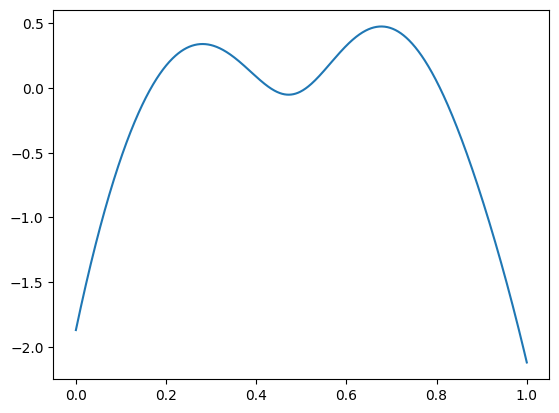

In [3]:
import matplotlib.pyplot as plt

X=np.linspace(0,1,num=1000).reshape(-1,1)
Y=kde.score_samples(X)
plt.plot(X,Y)

In [4]:
import math

def kernel(x,y,bandwidth=0.1):
  return math.exp(-(np.linalg.norm(x-y)**2)/(2*(bandwidth**2)))

def batch_private_kde(X,data,alpha=0.1,beta=0.1,bandwidth=0.1):
    cbeta=pow(2*math.log(2/beta),0.5)
    Gram_matrix=np.array([[kernel(x,y,bandwidth=bandwidth) for x in X] for y in X])
    return np.random.multivariate_normal(data,((cbeta*pow(2,0.5))/(alpha*len(data)*pow(2*math.pi*(bandwidth**2),len(X[0])/2)))*Gram_matrix,size=1)

In [5]:
from sklearn.metrics import mean_squared_error as mse
Z=[]
for alp in np.linspace(0.1,1,num=5):
  private_Y=batch_private_kde(X,Y,alpha=alp,beta=0.1,bandwidth=0.1)
  Z.append(mse(private_Y.reshape(-1),Y))

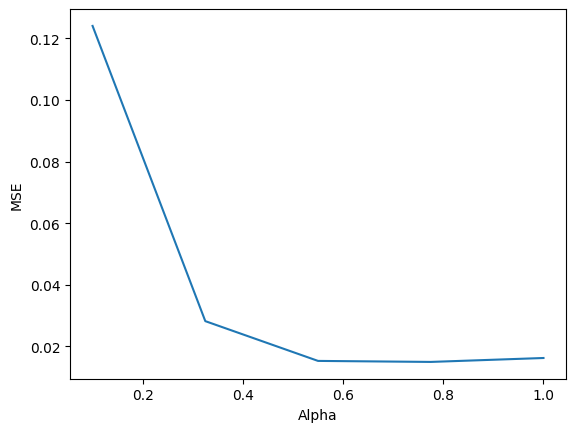

In [6]:
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.plot(np.linspace(0.1,1,num=5),Z)

Functions in sobolev space

In [7]:
import math

def kernel(x,y,bandwidth=0.1):
  return math.exp(-(np.linalg.norm(x-y)**2)/(2*(bandwidth**2)))

def batch_private_kde_sobo(X,data,alpha=0.1,beta=0.1,bandwidth=0.1):
    cbeta=pow(2*math.log(2/beta),0.5)
    Gram_matrix=np.array([[kernel(x,y,bandwidth=bandwidth) for x in X] for y in X])
    return np.random.multivariate_normal(data,((cbeta*2)/(alpha*len(data)*pow(2*math.pi*(bandwidth**4),len(X[0])/4)))*Gram_matrix,size=1)


In [8]:
from sklearn.metrics import mean_squared_error as mse
Z=[]
for alp in np.linspace(0.1,1,num=5):
  private_Y=batch_private_kde_sobo(X,Y,alpha=alp,beta=0.1,bandwidth=0.1)
  Z.append(mse(private_Y.reshape(-1),Y))

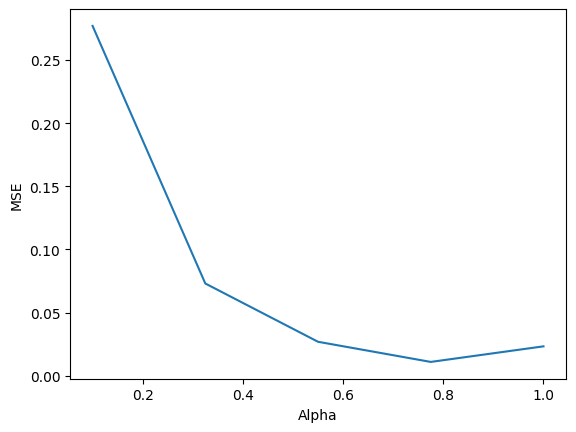

In [9]:
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.plot(np.linspace(0.1,1,num=5),Z)

SVM

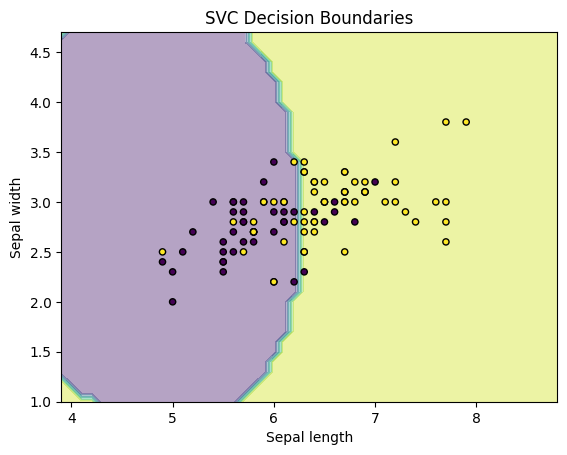

Training accuracy: 0.9571428571428572
Test accuracy: 0.8666666666666667


In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data[:,:]
y = iris.target

X = X[y != 0] #Dropping the first class
y = y[y != 0]
y-=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(C=0.1,kernel='rbf',gamma='auto')

model.fit(X_train, y_train)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x1_min, x1_max = X[:, 2].min() - 1, X[:, 2].max() + 1
y1_min, y1_max = X[:, 3].min() - 1, X[:, 3].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
xx1, yy1,xx11,yy11 = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1),
                       np.arange(x1_min, x1_max, 0.1),
                     np.arange(y1_min, y1_max, 0.1))
Z = model.predict(np.c_[xx.ravel(), yy.ravel(),[sum(X[:, 2])/len(X[:, 2])]*(1900),[sum(X[:, 3])/len(X[:, 3])]*(1900)])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC Decision Boundaries')
plt.show()
print("Training accuracy:" ,sum([x==y for x,y in zip(model.predict(X_train),y_train)])/len(y_train))
print("Test accuracy:" ,sum([x==y for x,y in zip(model.predict(X_test),y_test)])/len(y_test))

In [11]:
import math

# root(K(x,x))=1 for rbf
def kernel(x,y,bandwidth=0.1):
  return math.exp(-(np.linalg.norm(x-y)**2)*bandwidth)


def batch_private_model(X,data,alpha=0.1,beta=0.1,bandwidth=0.1,M=1,lamb=1):
    cbeta=pow(2*math.log(2/beta),0.5)
    Gram_matrix=np.array([[kernel(x,y,bandwidth=bandwidth) for x in X] for y in X])
    return np.random.multivariate_normal(data,((cbeta*M)/(alpha*len(data)*lamb))*Gram_matrix,size=1)

In [12]:
from sklearn.metrics import mean_squared_error as mse
Z1=[]
Z2=[]
for alp in np.linspace(0.1,2,num=10):
  Z1.append(sum([x==y for x,y in zip(batch_private_model(X_train,model.predict(X_train),alpha=alp,beta=0.1,bandwidth=1/len(X[0]),M=1,lamb=model.C)[0]>=0,y_train)])/len(y_train))
  Z2.append(sum([x==y for x,y in zip(batch_private_model(X_test,model.predict(X_test),alpha=alp,beta=0.1,bandwidth=1/len(X[0]),M=1,lamb=model.C)[0]>=0,y_test)])/len(y_test))

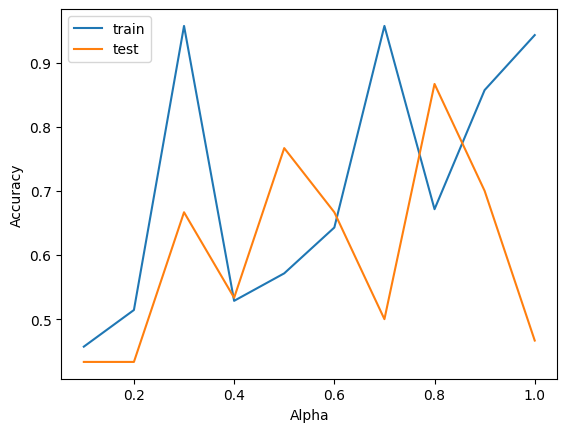

In [13]:
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.plot(np.linspace(0.1,1,num=10),Z1,label="train")
plt.plot(np.linspace(0.1,1,num=10),Z2,label="test")
plt.legend()
plt.show()

Online setting

In [14]:
def update_inv(Ainv,B,C,D):
  '''
  Using schur complement and matrix inversion lemma
  '''
  D= np.longdouble(D)
  C = C.astype(np.longdouble)
  B = B.astype(np.longdouble)
  Ainv = Ainv.astype(np.longdouble)
  B=B.reshape(-1,1)
  C=C.reshape(1,-1)
  MDinv=Ainv+(1/(D-(C@Ainv@B)))*(Ainv@B@C@Ainv)
  Dinv= 1/D
  return np.concatenate((np.concatenate((MDinv,(-(MDinv@B)*Dinv).reshape(-1,1)),axis=1),np.concatenate((-Dinv*(C@MDinv).reshape(1,-1),np.array([Dinv+Dinv*(C@MDinv@B)*Dinv]).reshape(1,1)),axis=1)),axis=0)
def private_model_online(no_of_queries,kernel,model_predict):
    x=np.longdouble(input("Enter the input:"))
    f=model_predict(np.array([x],dtype=np.longdouble).reshape(-1,1))
    print(f[0],f[0])
    Cinv=np.array([[1/kernel(x,x)]],dtype=np.longdouble)
    X=np.array([x],dtype=np.longdouble)
    G=np.array([f],dtype=np.longdouble)
    j=1
    for i in range(1,no_of_queries):
      x=np.longdouble(input("Enter the input:"))
      f=model_predict(np.array([x]).reshape(-1,1))
      f=np.longdouble(f)
      V=np.array([kernel(z,x) for z in X],dtype=np.longdouble)
      newf=np.random.normal((np.dot(np.dot(V,Cinv),G.T)).astype('float64'),(max(kernel(x,x)-np.dot(np.dot(V,Cinv),V.T),0)).astype('float64'))
      print(f,newf)
      Cinv=update_inv(Cinv,np.array([kernel(z,x) for z in X]).T,np.array([kernel(x,z) for z in X]),kernel(x,x))
      X=np.append(X,[x])
      G=np.append(G,[newf])

In [15]:
import numpy as np
mu=[0.3,0.7]
sigma=[0.1,0.1]
data=[]

for i in range(100):
  j=np.random.randint(2,size=1)[0]
  data.append(np.random.normal(mu[j],sigma[j],1))

from sklearn.neighbors import KernelDensity

kde=KernelDensity(bandwidth=0.1, algorithm='auto', kernel='gaussian', metric='euclidean', atol=0, rtol=0, breadth_first=True, leaf_size=40)
kde.fit(data)

def kernel(x,y):
  bandwidth=0.1
  return math.exp(-(np.linalg.norm(x-y)**2)/(2*(bandwidth**2)))

private_model_online(10,kernel,kde.score_samples)

KeyboardInterrupt: Interrupted by user

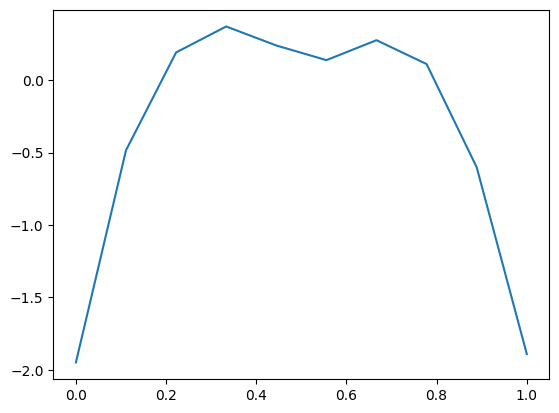

In [16]:
X=np.linspace(0,1,num=10).reshape(-1,1)
Y=kde.score_samples(X)
plt.plot(X,Y)

In [17]:
def update_inv(Ainv,B,C,D):
  '''
  Using schur complement and matrix inversion lemma
  '''
  D= np.longdouble(D)
  C = C.astype(np.longdouble)
  B = B.astype(np.longdouble)
  Ainv = Ainv.astype(np.longdouble)
  B=B.reshape(-1,1)
  C=C.reshape(1,-1)
  MDinv=Ainv+(1/(D-(C@Ainv@B)))*(Ainv@B@C@Ainv)
  Dinv= 1/D
  return np.concatenate((np.concatenate((MDinv,(-(MDinv@B)*Dinv).reshape(-1,1)),axis=1),np.concatenate((-Dinv*(C@MDinv).reshape(1,-1),np.array([Dinv+Dinv*(C@MDinv@B)*Dinv]).reshape(1,1)),axis=1)),axis=0)
def private_model_online_test(input,kernel,model_predict):
    input=input.astype(np.longdouble)
    outputs=[]
    x=input[0]
    f=model_predict(np.array([x],dtype=np.longdouble).reshape(-1,1))
    outputs.append(f[0])
    Cinv=np.array([[1/kernel(x,x)]],dtype=np.longdouble)
    X=np.array([x],dtype=np.longdouble)
    G=np.array([f],dtype=np.longdouble)
    j=1
    for x in input[1:]:
      f=model_predict(np.array([x]).reshape(-1,1))
      f=np.longdouble(f)
      V=np.array([kernel(z,x) for z in X],dtype=np.longdouble)
      newf=np.random.normal((np.dot(np.dot(V,Cinv),G.T)).astype('float64'),(max(kernel(x,x)-np.dot(np.dot(V,Cinv),V.T),0)).astype('float64'))
      outputs.append(newf)
      Cinv=update_inv(Cinv,np.array([kernel(z,x) for z in X]).T,np.array([kernel(x,z) for z in X]),kernel(x,x))
      X=np.append(X,[x])
      G=np.append(G,[newf])
    return outputs
private_Y=private_model_online_test(X,kernel,kde.score_samples)

In [18]:
print([(x,y) for x,y in zip(private_Y,Y)])

[(-1.9488129855961258, -1.9488129855961258), (array([-1.32337457]), -0.48452697106935627), (-1.3025834686459434, 0.19079434257321104), (-1.4187225657198423, 0.3700317153854371), (-1.559086848867862, 0.2389066475006718), (-1.0214159102714127, 0.13768473964075056), (-0.020201925876456528, 0.2753264696675508), (0.9643432011374131, 0.11065719609177904), (0.2506630078245719, -0.6018578287717435), (0.2178076514148483, -1.890337842317587)]


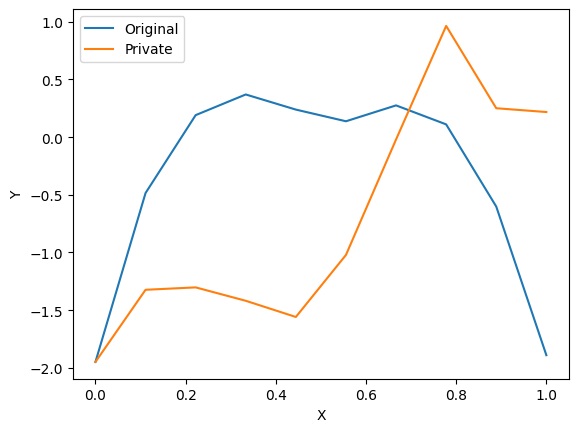

In [19]:
private_Y[1]=private_Y[1][0]
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(X,Y,label="Original")
plt.plot(X,private_Y,label="Private")
plt.legend()
plt.show()

In [ ]:
'''
Side note the precision is a big problem as the number of queries get large, So the online method will get affected by it as we increase the number of queries
'''